# Example: Assigning new patients to phenotypes
We identified 4 clusters in RA (Rheumatoid arthritis) with deep embedded clustering on tabular lab & clinical data. However, to ensure that this isnt just an incidental finding, we recruit a different set of patients for replication. We apply the autoencoder model trained on the initial development set to project these new patients on the learned latent space. Given their orientiation, and their closest neighbours* (patients presenting with the same clinical characteristics from the initial set), we can provide each new patient with a cluster label.

*Another name for these neighbours is: digital twins.  

#### Difference in dimensionality
In this example, there is a difference in dimensionality between the development set and the replication set. Hence, we build a reduced latent space with the features we know to be present in both datasets. Whereby, the original clustering information, defined on the complete data from the development set, remains in tact. We will use the original clustering information to assign the new patients instead of re-clustering with incomplete data, as we assume that the essence of each cluster is preserved in this reduced space.  

Be careful though: If clinical data is absent in the external set (like this example), one should ensure that at least the key-features are present. Otherwise, the tool will render non-sensible output. You'll find some visualization tools down below to detect the differences in quality.

## Step 1. Construct shared product space 
### 1.1 Import data
We import data from both the development set as well as the replication set. Each set has two different data modalities (numerical and categorical features), which are saved in seperate tables. Hence, we open 4 files in total.

In [4]:
import numpy as np
import pandas as pd

# Set seed
np.random.seed(0)

# Variables from development set
df_numeric = pd.read_csv('../example_data/development/ClusteringDEV_NUMERIC.csv', sep=',')[['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',  'MCV', 'Trom', 'BSE', 'Lym', 'Mono', 'Age']] # 
df_categoric= pd.read_csv('../example_data/development/ClusteringDEV_CATEGORICAL.csv', sep=',')

# Load modalities from replication set
df_categoric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_CATEGORICAL.csv', sep=',')
df_numeric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_NUMERIC.csv', sep=',')[['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',  'MCV', 'Trom', 'BSE', 'Lym', 'Mono', 'Age']]

# Original clustering information (same samples as development set)
df_cluster = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv')[['pseudoId', 'PhenoGraph_clusters']]

### 1.2 Force same dimensions
We have less features in the replication set, thus we are required to reduce the dimensions in order to create a shared latent space in step 1.3

In [5]:
print('|CATEGORICAL|')
print('BEFORE: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_categoric.columns), len(df_categoric_replication.columns)))

# Only keep categorical variables that are also in the replication set!
l_cat = [col for col in df_categoric.columns if col in df_categoric_replication.columns]

# Only keep variables relevant for clustering
l_cat = [col for col in l_cat if col not in ['FirstConsult', 'patnr', 'pseudoId']] 

df_categoric = df_categoric[l_cat].copy()
df_categoric_replication = df_categoric_replication[l_cat].copy()
             
print('AFTER: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_categoric.columns), len(df_categoric_replication.columns)))

|CATEGORICAL|
BEFORE: Columns: development set (n=322) vs replication set (n=196) 
AFTER: Columns: development set (n=195) vs replication set (n=195) 


#### Same for numerical data

In [6]:
# Only keep numerical variables that are also in the replication set!
print('|NUMERICAL|')
print('BEFORE: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_numeric.columns), len(df_numeric_replication.columns)))
l_num = [col for col in df_numeric.columns if col in df_numeric_replication.columns]
l_num = [col for col in l_num if col not in ['FirstConsult', 'patnr', 'pseudoId']] 
df_numeric = df_numeric[l_num].copy()
df_numeric_replication = df_numeric_replication[l_num].copy()       
print('AFTER: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_numeric.columns), len(df_numeric_replication.columns)))

|NUMERICAL|
BEFORE: Columns: development set (n=11) vs replication set (n=11) 
AFTER: Columns: development set (n=11) vs replication set (n=11) 


### 1.3 Learn shared product space (Example: MAUI)
We used the autoencoder architecture of MAUI as an example. However, one could also adopt a different deep learning architecture or even a factor analysis technique (like MOFA).

Time to create shared product space: 168.3922083377838
Z-merged shape: (1003, 70)


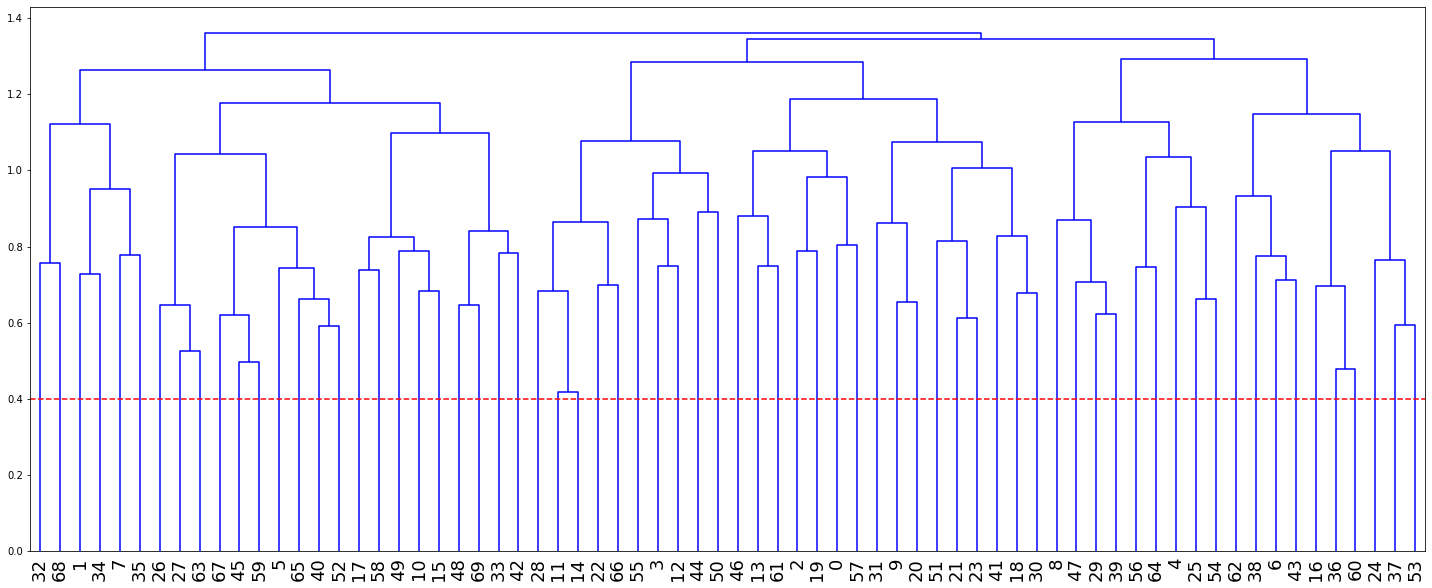

In [7]:
from keras import backend as K
import maui
import maui.utils
import time

#from keras import backend as K
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

# Build the model on the shared product space
t0 = time.time()
maui_model = maui.Maui(n_hidden=[150], n_latent=70, epochs=1000)
z = maui_model.fit_transform({ 'Categorical': df_categoric.T, 'Lab_numerical': df_numeric.T})
t1 = time.time()
print('Time to create shared product space: ' + str(t1-t0))

# Merge similar latent factors 
z_merged = maui_model.merge_similar_latent_factors(distance_threshold=.4)
print('Z-merged shape:', z_merged.shape)

# Drop latent factors which barely explain any variance
z_filtered = maui_model.drop_unexplanatory_factors()

# Save maui model state (that only uses variables also present in replication set)
maui_model.save('../example_data/model/replication_maui')

# Save shared productspace (that only uses variables also present in replication set)
df = z_filtered.copy()
df.insert(0, 'pseudoId', df_cluster['pseudoId'])
df.to_csv('../example_data/embedding/SharedProductSpace_embedding.csv', index=False, sep=',')

## Step 2. Project patients
You can start from step 2, if you already have a MAUI model

### 2.1 Load external data (& digital twin information)
We import the pruned data (see step 1.2), as well as the clustering information

In [1]:
import numpy as np
import pandas as pd

# Load modalities from replication set
df_categoric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_CATEGORICAL.csv', sep=',')
df_numeric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_NUMERIC.csv', sep=',')

# Bookmark identifier (use fake)
df_id = pd.DataFrame({'pseudoId' : ['id_' + str(i) for i in range(len(df_numeric_replication))]})

# Only keep variables eligible for clustering
l_remove = ['pseudoId']
df_categoric_replication = df_categoric_replication[[col for col in df_categoric_replication.columns if col not in l_remove]]
df_numeric_replication = df_numeric_replication[[col for col in df_numeric_replication.columns if col not in l_remove]]

# Original clustering information (same samples as development set)
df_cluster = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv')[['pseudoId', 'PhenoGraph_clusters']]

#### Load previously trained model
Either Deep learning or Latent Factor Analysis

In [2]:
import maui
maui_model = maui.Maui.load('../example_data/model/replication_maui')

Using TensorFlow backend.
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

#### Load previously constructed latent space

In [3]:
z_existent = pd.read_csv('../example_data/embedding/SharedProductSpace_embedding.csv',sep=',')
z_existent = z_existent.loc[:, z_existent.columns != 'pseudoId']

### 2.2 Initialize variables for patient assignment

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Construct patient similarity matrix from original set
sim_matrix = cosine_similarity(z_existent.astype(np.float32))

# Specify columns for each modality (need to be present in both original & replication space)
d_input = {'cat' : list(df_categoric_replication.columns), 'num' : list(df_numeric_replication.columns)}

# Intialize list to save location of newly projected patients
z_new = []

# Initialize dataframe where we register the probabiltiy
df_projection = pd.DataFrame(columns=['pseudoId', 'Proba_cluster1', 'Proba_cluster2', 'Proba_cluster3', 'Proba_cluster4'])

### 2.3 Project the patients onto latent space

In [5]:
import sys
sys.path.append(r'../')
from poodle import utils as pup
import time

# Start the timer
t0 = time.time()

# Classify loop
for ix in range(len(df_categoric_replication)): 

    # collect sample information
    new_pat = str(df_id.iloc[ix]['pseudoId'])
    sample_cat = df_categoric_replication.iloc[ix]
    sample_num = df_numeric_replication.iloc[ix]
    sample = sample_cat.append(sample_num)
    sample.name = new_pat
    
    # create metadata
    df_meta = pup.getMetaDataPatient(df_cluster, list(df_cluster['pseudoId'].values), new_pat)
    
    # project & classify patients
    y, z = pup.predictPatientCluster(maui_model, df_meta, z_existent, d_input, sample, sim_matrix) 
    
    # collect coordinates of all newly added patients
    z_new.append(np.array(z)[-1])

    # Add patient id to list of probabilities
    y.insert(0, new_pat)
    
    # Add probabilities of patient to projection dataframe
    df_projection.loc[len(df_projection)] = y 

# Stop the timer
t1 = time.time()
print('Time to project patients (n=%s) into product space: %s' % (str(len(df_projection)), str(t1-t0))) 

df_projection['PredictedCluster'] = df_projection.apply(lambda x : pup.getClusterLabel(x), axis=1)
df_projection.to_csv('../example_data/results/ClusterAssignment_METEOR.csv', index=False, sep=',')
pd.DataFrame(z_new).to_csv('../example_data/embedding/SharedProductSpace_embedding_Replication.csv',sep=',')

Time to project patients (n=587) into product space: 291.62366580963135


## Step 3. Visualize the learned embedding
### 3.1 Initialize variables


In [17]:
import sys
sys.path.append(r'../')
from poodle import utils as pup
import pandas as pd
import numpy as np

# Load product space
z_existent = pd.read_csv('../example_data/embedding/SharedProductSpace_embedding.csv',sep=',', index_col=0)
z_new = np.array(pd.read_csv('../example_data/embedding/SharedProductSpace_embedding_Replication.csv',sep=',', index_col=0))

# Load modalities from replication set
df_categoric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_CATEGORICAL.csv', sep=',')
df_numeric_replication = pd.read_csv('../example_data/replication/ClusteringMETEOR_NUMERIC_raw.csv', sep='|')[['pseudoId', 'MCV','Ht','Leuko','MCHC','MCH','BSE','Hb','Trom','Lym','Mono', 'Age']] # use raw for metadata
df_projection = pd.read_csv('../example_data/results/ClusterAssignment_METEOR.csv', sep=',')

# Get Original clustering metadata (same samples as development set)
metadata = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv', index_col=0)
metadata['Replication']=0

# Create metadata for new patients
df_replication = pd.merge(df_categoric_replication, df_numeric_replication, on='pseudoId')
df_replication['Replication']=1 
df_replication['PhenoGraph_clusters'] = len(metadata['PhenoGraph_clusters'].unique())+1

# Add projected patients to original set
print('BEFORE: total samples for tsne: ', len(metadata))
metadata_total, z_total = pup.add_projected_patients(metadata, z_existent, df_replication, pd.DataFrame(z_new, columns=z_existent.columns)) # ix = 
print('After: total samples for tsne: ', len(metadata_total))

BEFORE: total samples for tsne:  1003
After: total samples for tsne:  1590


### 3.2 Perform dimension reduction with t-SNE
We will project all new patients onto the latent space. And compare the two mappings to see if there are any batch effects.

#### Fit parametric t-SNE

In [7]:
import sys
sys.path.append(r'../../modules/parametric_tsne/')
from parametric_tSNE import Parametric_tSNE

new_tSNE = Parametric_tSNE(z_existent.shape[1], num_outputs=2, perplexities=30, seed=1234567) # , all_layers=all_layers
new_tSNE.fit(z_existent.values) # random_state=SEED+1, , metric='minkowski' # how many epochs??

Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Project both original and replication samples

In [3]:
# Transform exploratory data
fit1 = new_tSNE.transform(z_existent.values)
# Create interactive bokeh plot for more information
pup.plot_interactive_tsne(fit1, metadata, list(metadata.columns), l_binary=list(df_categoric_replication.columns), patient_id='pseudoId', cluster_id='PhenoGraph_clusters', path='../tsne/ProductSpace_2d_Original.html')

# Project replication data onto tSNE
fit2 = new_tSNE.transform(z_total.values)
# Create interactive bokeh plot for more information
pup.plot_interactive_tsne(fit2, metadata_total, list(metadata_total[df_replication.columns].columns), l_binary=list(df_categoric_replication.columns), patient_id='pseudoId', cluster_id='Replication', path='../tsne/ProductSpace_2d_Replication.html')

# Save tSNE with pickle
new_tSNE.save_model('../example_data/model/tsne/tsne_mapping')


UMAP figure saved under location: ../tsne/ProductSpace_2d_Original.html

UMAP figure saved under location: ../tsne/ProductSpace_2d_Replication.html


### 3.3 Check for batch effects 

In [ ]:
pup.plot_tsne(fit1, group_id=metadata['Replication'], path='../figures/original/tsne_original.png')
pup.plot_tsne(fit2, group_id=metadata_total['Replication'], path='../figures/replication/tsne_replication_projected.png')

Product space (2D representation)            |  Newly projected patients on product space
:-------------------------:|:-------------------------:
![tsne_original](../figures/original/tsne_original.png)  |  ![tsne_replicate](../figures/replication/tsne_replication_projected.png)

### 3.4 Project a single patient

BEFORE: total samples for tsne:  1003
After: total samples for tsne:  1004

UMAP figure saved under location: ../tsne/ProductSpace_2d_Replication_pt582.html


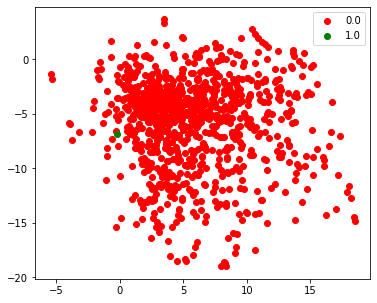

In [9]:
# Project a single patient onto original set
print('BEFORE: total samples for tsne: ', len(metadata))
metadata_, z_ = pup.add_projected_patients(metadata, z_existent, df_replication, pd.DataFrame(z_new, columns=z_existent.columns), ix=582) 
print('After: total samples for tsne: ', len(metadata_))

# Project new patient onto tSNE
fit3 = new_tSNE.transform(z_.values)
# Create interactive bokeh plot for more information
pup.plot_interactive_tsne(fit3, metadata_, list(metadata_[df_replication.columns].columns), l_binary=list(df_categoric_replication.columns), patient_id='pseudoId', cluster_id='Replication', path='../tsne/ProductSpace_2d_Replication_pt582.html')

# Look at location
#pup.plot_tsne(fit1, group_id=metadata['Replication'], path='../figures/original/tsne_original_pt582.png')
pup.plot_tsne(fit3, group_id=metadata_['Replication'], path='../figures/replication/tsne_replication_pt582.png')

## Step 4. Evaluate replicate clusters 
We will compare the replicate clusters to the original ones, by examining the baseline characteristics and shap figures.

### 4.1 Check quality of replicate clusters vs  shared product space

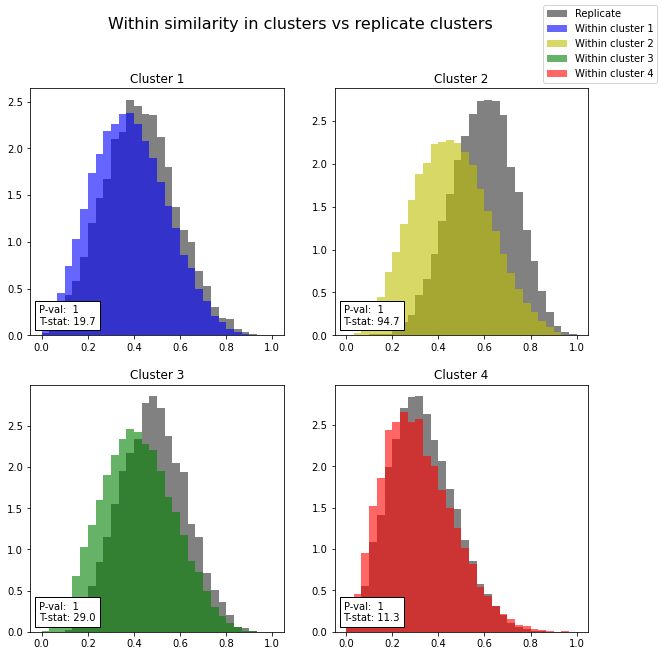

In [8]:
from poodle import visualization as viz

viz.plotQualityControl(metadata[['PhenoGraph_clusters', 'pseudoId']], df_projection, z_existent, pd.DataFrame(z_new))

#### And how does it compared to the complete product space?

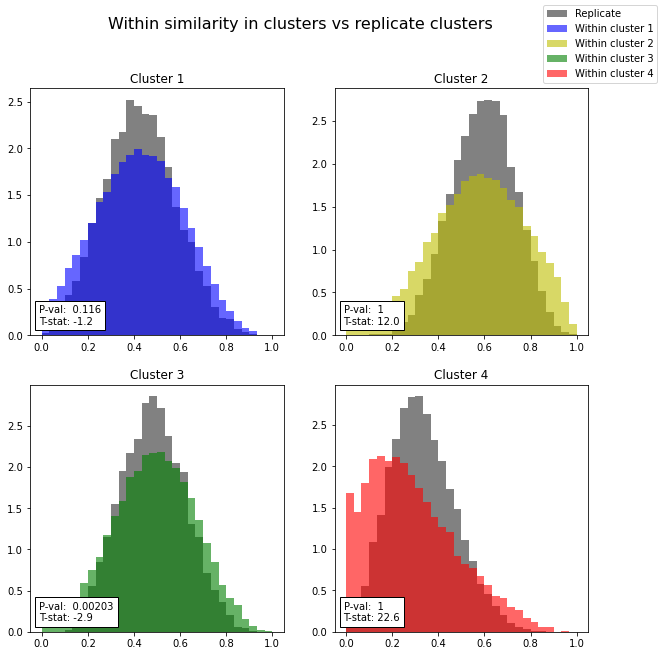

In [14]:
# Original (& complete) product space
Z = pd.read_csv('../example_data/embedding/FullProductSpace_embedding.csv')
Z = Z[Z.columns[4:]]
viz.plotQualityControl(metadata[['PhenoGraph_clusters', 'pseudoId']], df_projection, Z, pd.DataFrame(z_new)) 

### 4.2 Look at the spatial variation

Spatial variance in replication set: 	C1= 115; C2= 161; C3= 95; C4= 216
Spatial variance in original set: 	C1= 299; C2= 290; C3= 243; C4= 171


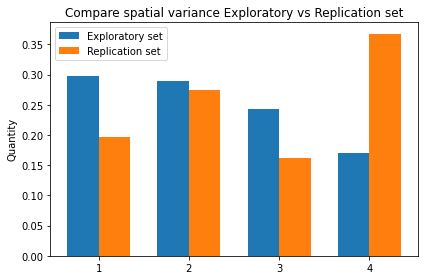

In [9]:
from collections import Counter
from poodle import visualization as viz

c = Counter(df_projection['PredictedCluster'])
l_new = [c[ix]/sum(c.values()) for ix in range(1,len(c)+1)]
print('Spatial variance in replication set: \tC' + '; C'.join([str(ix) + '= ' + str(c[ix]) for ix in range(1,len(c)+1)]))
c = Counter(metadata['PhenoGraph_clusters'])
l_old = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in original set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))

viz.plotSpatialVariation(l_new, l_old)

## Step 5 Downstream analysis
- Zoom into a particular patient - to gain insight into the cluster assignment procedure

### 5.1 Map a specific patient (patient 582)

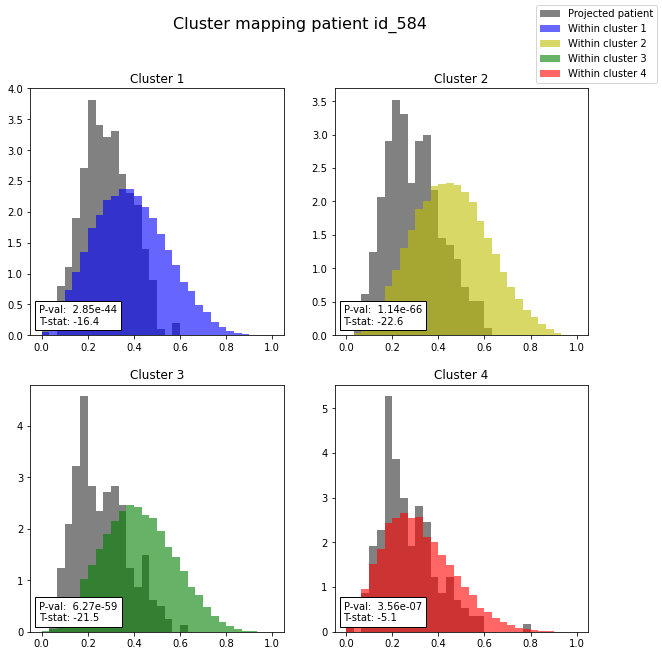

In [10]:
ix = 584 

# collect sample information
new_pat = str(df_id.iloc[ix]['pseudoId'])
sample_cat = df_categoric_replication.iloc[ix]
sample_num = df_numeric_replication.iloc[ix]
sample = sample_cat.append(sample_num)
sample.name = new_pat

# create metadata
df_meta = pup.getMetaDataPatient(df_cluster, list(df_cluster['pseudoId'].values), new_pat)

# project & classify patients
y, z = pup.predictPatientCluster(maui_model, df_meta, z_existent, d_input, sample) 

viz.plotClusterMapping(df_meta, z, new_pat)

#### Print out probabilities

In [11]:
print('|Calculated probabilities for pat %s|\nC' % str(ix) + '\nC'.join([str(ix+1) + '= %.2f' % (y[ix]) for ix in range(0,len(y))]))

|Calculated probabilities for pat 584|
C1= 0.12
C2= 0.08
C3= 0.08
C4= 0.72


### 5.2 Show top 10 closest neighbours for patient

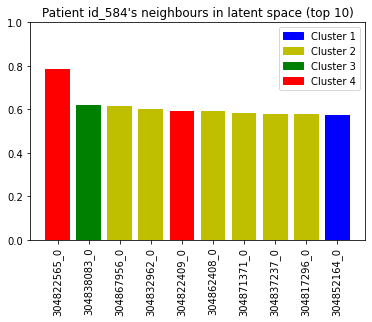

In [12]:
df_neighbours = pup.find_neighbours(df_meta, z, new_pat)
viz.plot_neighbours(df_neighbours, new_pat)

## Step 6 Compare SHAP plots for further evaluation
We will build a surrogate model for the replication set, to see if the SHAP swarm plots compare to the original set as a means of validation.

### 6.1 Construct a complete profile 

In [33]:
# Replication clustering information 
df_cluster = pd.read_csv('../example_data/results/ClusterAssignment_METEOR.csv', sep=',')
df_cluster = df_cluster[[col for col in df_cluster.columns if col not in ['pseudoId']]]

# Add categorical data
df_categoric_replication = df_categoric_replication[[col for col in df_categoric_replication.columns if col not in ['pseudoId']]]
df_profile = df_categoric_replication.merge(df_cluster, left_index=True, right_index=True)

# Add numerical data
df_profile = df_profile.merge(df_numeric_replication[['MCV', 'Ht', 'Leuko', 'MCHC', 'MCH', 'BSE', 'Hb',
       'Trom', 'Lym', 'Mono', 'Age']], left_index=True, right_index=True)

### 6.2 Calculate SHAP values with a surrogate model

In [34]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Preload function
def strip_right(df, suffix='_positive'):
    df.columns = df.columns.str.replace(suffix+'$', '', regex=True)
strip_right(df_profile)

# 1. Create training & test set
cols_interest = [col for col in df_profile.columns if col not in ['pseudoId', 'Proba_cluster1', 'Proba_cluster2', 'Proba_cluster3',
       'Proba_cluster4']]
cols_interest = [col for col in cols_interest if 'negative' not in col]
    
target = 'PredictedCluster'


df_train, df_test = train_test_split(df_profile[cols_interest], test_size=0.2, stratify=df_profile[target], random_state=28072022)

# 2. Fitting the model
cols_data = [x for x in list(cols_interest) if x not in [target]] 

X = df_train[cols_data].values
y = df_train[target] - 1


### 6.3 K-fold cross validation

In [35]:
# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    y_train, y_test = np.take(y, np.array(train_index)), np.take(y, np.array(test_index))

    # Normalize
    fit_gaussian = False

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)

    t0 = time.time()
    bst  = xgb.train({'objective': 'multi:softmax', 'num_class':len(y.unique())}, dmat_train,
                        n_trees, evals=[(dmat_train, "train"), (dmat_test, "test")]) # "tree_method": "gpu_hist", 
    t1 = time.time()
    print('Time for Training XGB model %s: %s' % (str(iteration+1), str(t1-t0)))
    iteration += 1
    
    # Create a confusion matrix over all data!
    y_pred.extend(bst.predict(dmat_test))


TRAIN: [ 94  95  96  97  98  99 100 101 102 103] TEST: [0 1 2 3 4 5 6 7 8 9]
[17:36:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.05483	test-mlogloss:1.14361
[1]	train-mlogloss:0.83795	test-mlogloss:1.01647
[2]	train-mlogloss:0.68427	test-mlogloss:0.93632
[3]	train-mlogloss:0.57050	test-mlogloss:0.87224
[4]	train-mlogloss:0.46991	test-mlogloss:0.81084
[5]	train-mlogloss:0.40116	test-mlogloss:0.77140
[6]	train-mlogloss:0.34527	test-mlogloss:0.75304
[7]	train-mlogloss:0.29565	test-mlogloss:0.72662
[8]	train-mlogloss:0.25714	test-mlogloss:0.70155
[9]	train-mlogloss:0.22750	test-mlogloss:0.68820
[10]	train-mlogloss:0.19998	test-mlogloss:0.66377
[11]	train-mlogloss:0.17665	test-mlogloss:0.64820
[12]	train-mlogloss:0.15967	test-mlogloss:0.64328
[13]	train-mlogloss:0.14209	tes

[43]	train-mlogloss:0.02530	test-mlogloss:0.47505
[44]	train-mlogloss:0.02463	test-mlogloss:0.47503
[45]	train-mlogloss:0.02399	test-mlogloss:0.47558
[46]	train-mlogloss:0.02333	test-mlogloss:0.47517
[47]	train-mlogloss:0.02278	test-mlogloss:0.47572
[48]	train-mlogloss:0.02224	test-mlogloss:0.47542
[49]	train-mlogloss:0.02174	test-mlogloss:0.47568
Time for Training XGB model 3: 1.0532464981079102
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [282 283 284 285 286 287 288 289 290 291]
[17:36:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.04158	test-mlogloss:1.13308
[1]	train-mlogloss:0.83512	test-mlogloss:0.99021
[2]	train-mlogloss:0.69157	test-mlogloss:0.88256
[3]	train-mlogloss:0.57825	test-mlogloss:0.80335
[4]	train-mlogloss:0.48973	test-mlogloss:0.75263
[5]	train-mlogloss:0.40738

### 6.4 Infer quality of surrogate model

Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.76)')

<Figure size 432x288 with 0 Axes>

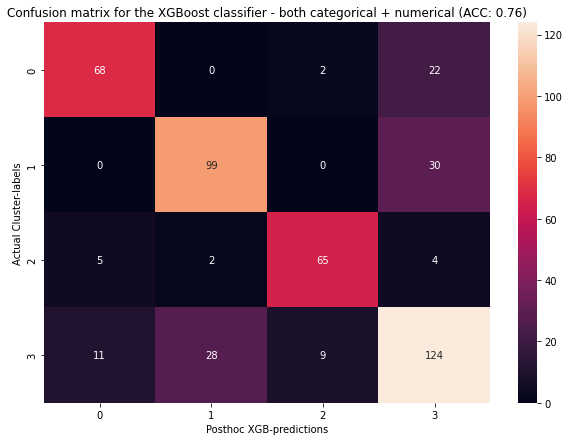

In [36]:
# PLot
fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

### 6.5 Compute & visualize SHAP values

In [37]:
t0 = time.time()
#shap_values = bst.predict(dmat_test, pred_contribs=True)
t_explainer = shap.TreeExplainer(bst) # or just X?
shap_values = t_explainer.shap_values(X_test)
t1 = time.time()
print('Calculating SHAP: ' + str(t1-t0))

# Plot each class
for class_idx in range(len(y.unique())):
    fig = shap.summary_plot(shap_values[class_idx], X_test, cols_data, show=False, max_display=15) # default = 20
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    plt.savefig('../figures/replication/shap%s_replicate.png' % (str(class_idx)))
    plt.clf()

Calculating SHAP: 0.23497819900512695


<Figure size 576x540 with 0 Axes>

### 6.6 Compare SHAP plots

Original clusters            |  Replicate clusters
:-------------------------:|:-------------------------:
![shap1_original](../figures/original/shap1_original.png)  |  ![shap1_replicate](../figures/replication/shap0_replicate.png)
![shap2_original](../figures/original/shap2_original.png)  |  ![shap2_replicate](../figures/replication/shap1_replicate.png)
![shap3_original](../figures/original/shap3_original.png)  |  ![shap3_replicate](../figures/replication/shap2_replicate.png)
![shap4_original](../figures/original/shap4_original.png)  |  ![shap4_replicate](../figures/replication/shap3_replicate.png)

## 7. Future steps:
- compare baseline characteristics
- add tsne step (to elucidate potential batch effect) -> before or right after step 2
- add batch correction step (pyComBat or Harmony?)